In [1]:
import numpy as np
import pandas as pd
import os
import torch 
from torch import nn, optim 
from torchvision import datasets, transforms, models
import torch.utils.data
import matplotlib.pyplot as plt
import time
import random

## To Do:

* add Data augmentation
* look at andrej Karpathy neural network advice and implement it here
* Make the recall print
* Fix accuracy metrics
* Make Learning rate change across batches

* Explore Variations and stuff

* Try new range optimizer that works really well 
* Read paper
https://arxiv.org/pdf/1907.08610.pdf






#### Pip Install and import other packages

In [ ]:
!pip install pytorch_lightning

In [3]:
from pytorch_lightning.metrics import Accuracy, Metric, F1, Precision, Recall

In [4]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [5]:
#Uncomment to load data in
import tarfile
my_tar = tarfile.open('/content/drive/MyDrive/imagewoof2-160.tgz')
my_tar.extractall() # specify which folder to extract to
my_tar.close()

In [6]:
data_dir = "/content/imagewoof2-160"
batch_size = 64
#Set random seed
random.seed(42)

train_transform = transforms.Compose([
                                      transforms.Resize(255),
                                      transforms.RandomCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(20),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_transform = transforms.Compose([
                                     transforms.Resize(255),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


train_data = datasets.ImageFolder(os.path.join(data_dir, "train"), transform = test_transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, "val"), transform = test_transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

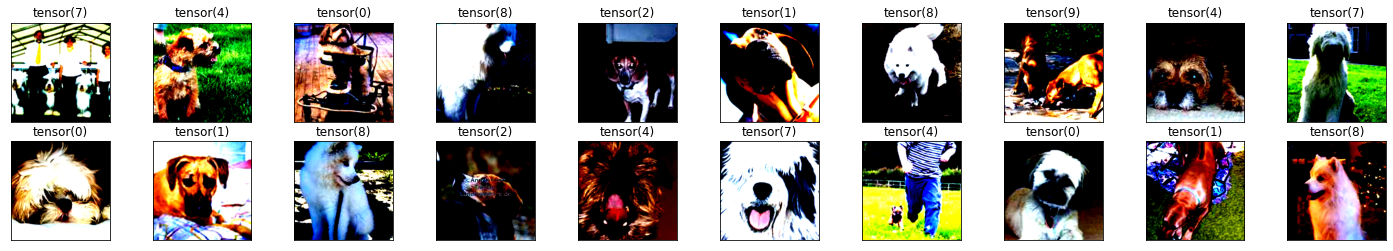

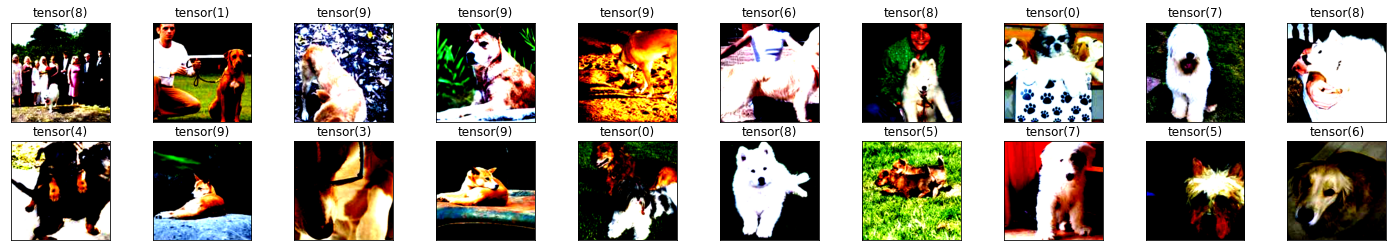

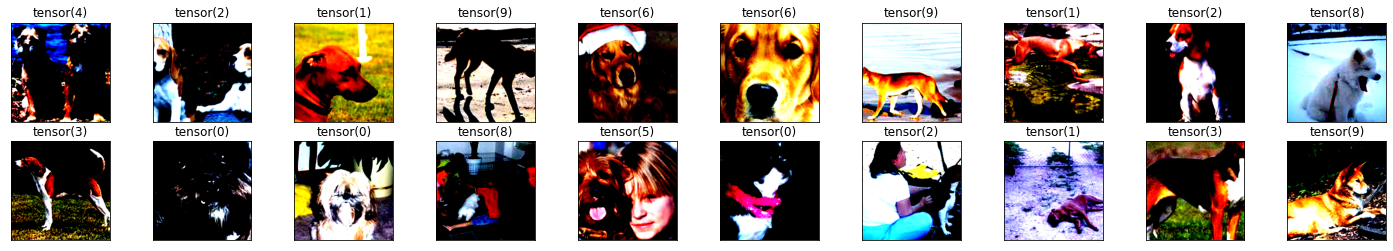

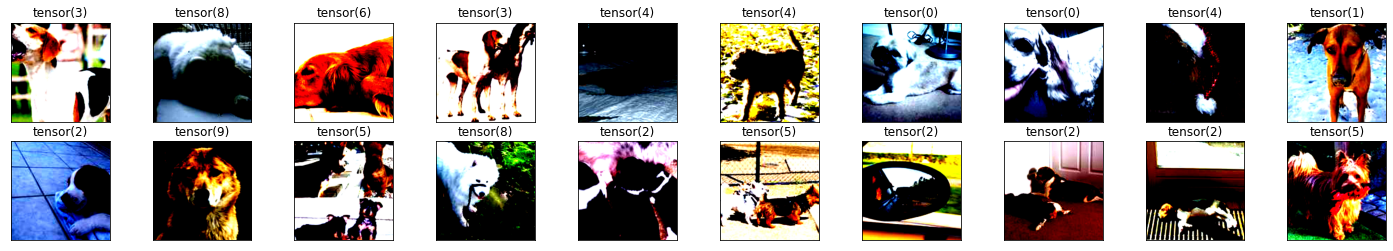

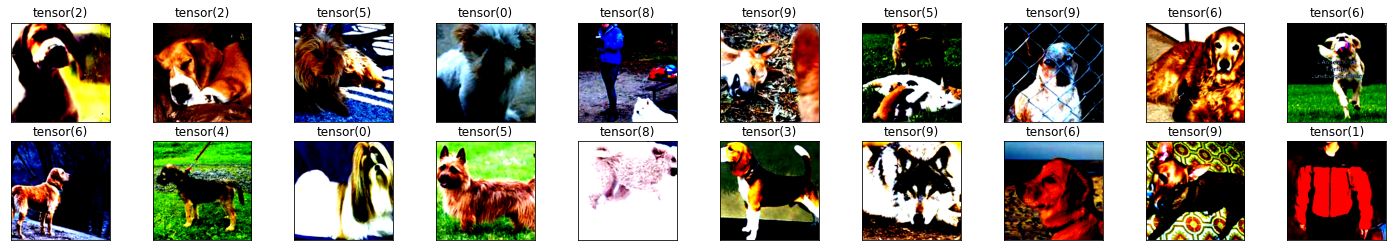

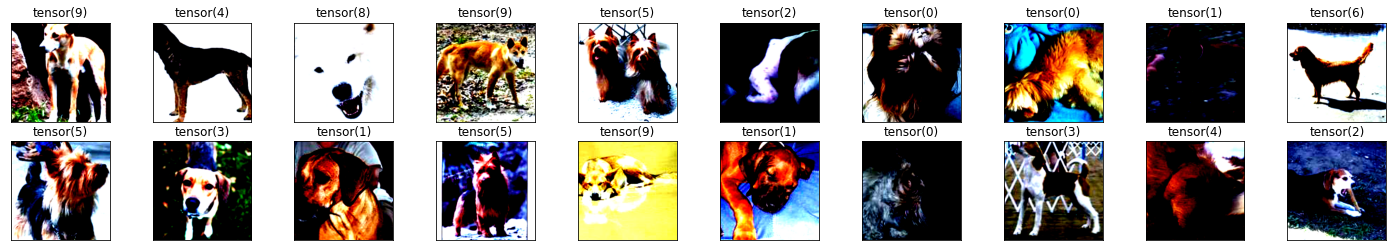

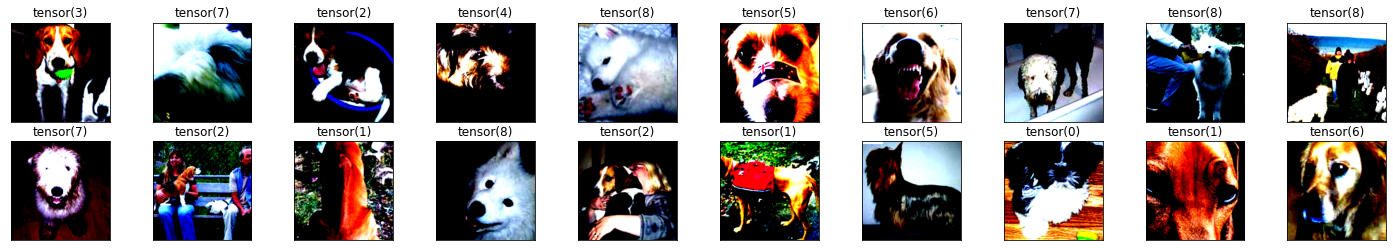

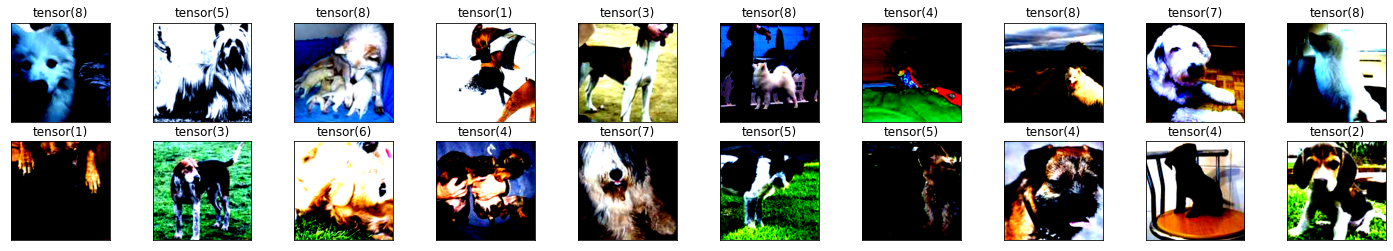

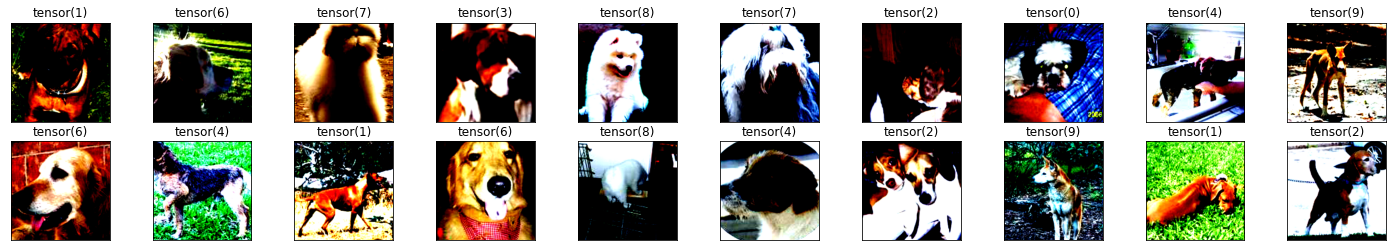

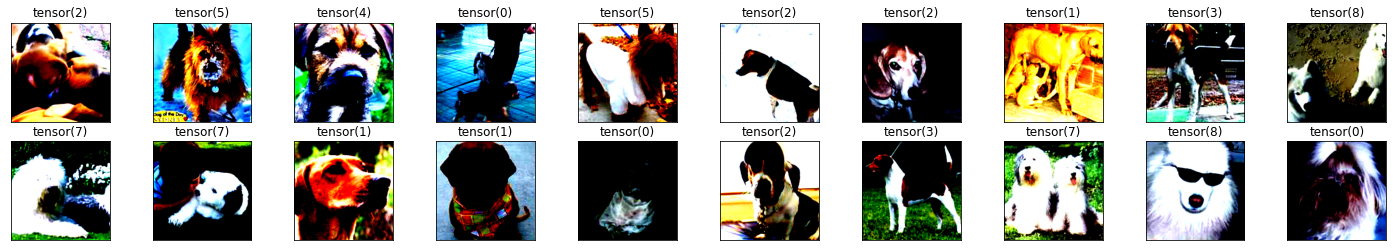

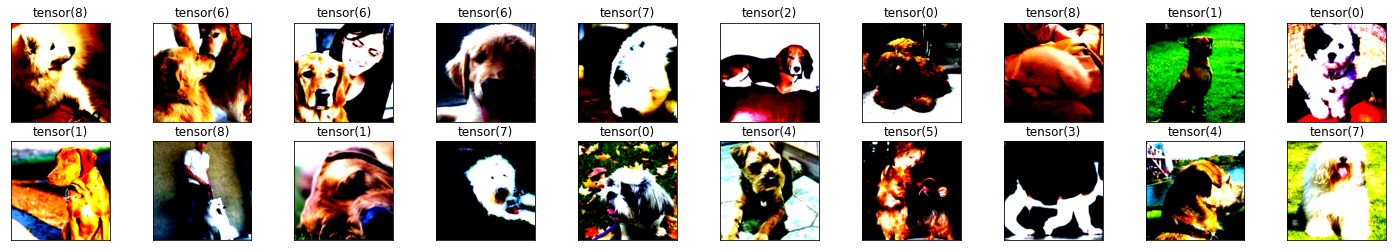

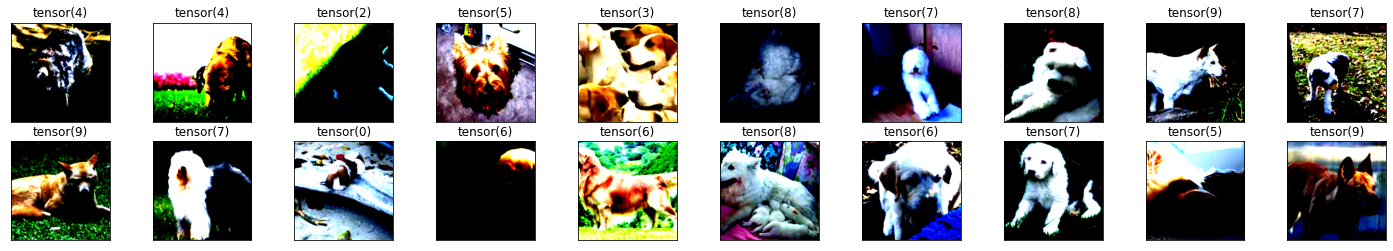

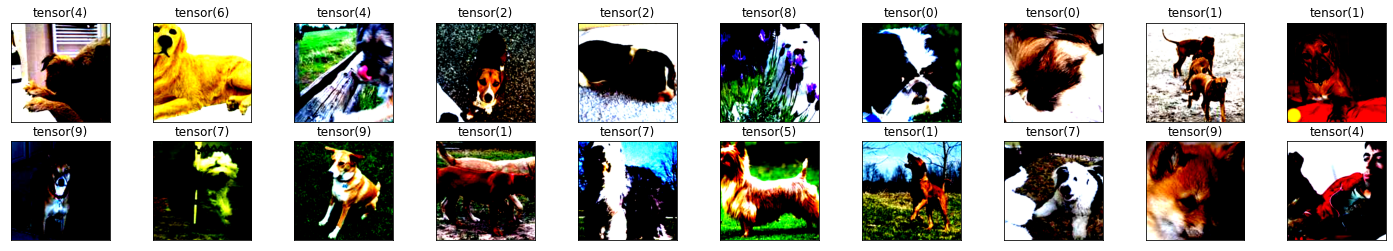

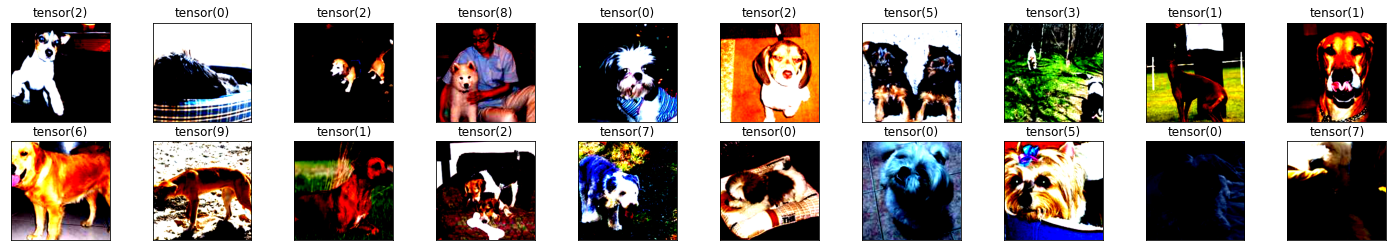

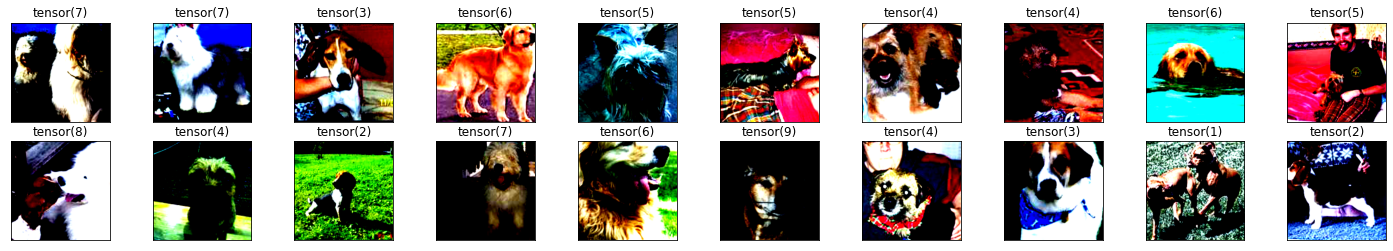

In [ ]:
dataiter = iter(train_loader)
for i in range(15):

  
  images, labels = dataiter.next()
  images = images.numpy()


  # plot the images in the batch, along with the corresponding labels
  fig = plt.figure(figsize=(25, 4))
  for idx in np.arange(20):
      ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
      plt.imshow(np.transpose(images[idx], (1, 2, 0)))
      ax.set_title(labels[idx])

  

## Explore Data

As an example - are very local features enough or do we need global context? How much variation is there and what form does it take? What variation is spurious and could be preprocessed out? Does spatial position matter or do we want to average pool it out? How much does detail matter and how far could we afford to downsample the images? 

* Global Features are the most important
* Variations (U - means useless for classification, * - Means important)
 * Position of Dogs - U
 * Presence of Human - U
 * Spatial Information - U (Location, Configuration, etc.) Avg Pool Models or Adaptive Avg Pool (or anything to that nature) would work. 
 * Color of the Dog - * 
 * Texture of the Dog - * 
 * Edge Fluffiness - *
 * Shape of face of dog (long face or short face) - *

 POSSIBLE THINGS TO EXPLORE:
 * Use Augmentation to rotate image
 * Use Face Haar Cascade to recognize human and white out face
 (Look in the Dog Breed classifier code to only white out face if it recognizes human). 
 * Use AvgPool in end of layer

 


## Entire Train and Test Function and Visualizer

In [14]:
def Graph_Maker(Train_l,Test_L, print_every, x_ticks_list):
  epoch_count = range(1, len(Train_l) + 1)
  plt.title("Loss vs. [Check Train Note]")
  plt.xlabel("Number of {} Training Batches".format(print_every))
  plt.ylabel("Loss")
  plt.plot(epoch_count,Train_l, 'r--')
  plt.plot(epoch_count,Test_L, 'b-')
  plt.legend(['Training Loss', 'Test Loss'])
  plt.xticks(x_ticks_list)
  plt.show()

In [15]:
def train(net, epochs, train_loader, test_loader, lr, criterion, print_every = 40, weight_decay = 0, new_optim = None):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #Create metrics
    test_accuracy = Accuracy(compute_on_step = False).to(device)
    train_accuracy = Accuracy(compute_on_step = False).to(device)
    test_prec = Precision(num_classes=10, compute_on_step = False).to(device)
    test_recall = Recall(num_classes=10, compute_on_step = False).to(device)
    test_f1 = F1(num_classes=10, compute_on_step = False).to(device) 

    if new_optim:
      optimizer = optim
    else:
      optimizer = optim.Adam(net.parameters(), lr = lr, weight_decay = weight_decay)
      
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = len(train_loader) * epochs)
    
    net.to(device)
    print("Device: {}".format(device))
    print("Optimizer: {}".format(optimizer))
    print("Note: Train Loss is calculated after {} batches of the train loader. While the test loss is calculated over the whole test_loader".format(print_every))
    print("For example: a sequence might be train for {} batches then test on everything and then train for the next {} batches then test on everything ... ".format(print_every, print_every))
    
    start_time = time.time()

    #For graphing
    train_list = []
    test_list = []
    total_batches_axis = [0]
    
    for epoch in range(epochs):
        net.train()
        
        train_loss = 0
        steps = 0
        
        for batch_idx, (image, label) in enumerate(train_loader):
            
            steps += 1
            if device == torch.device("cuda"):
                image = image.cuda()
                label = label.cuda()
                
            optimizer.zero_grad()
            output = net(image)
            train_accuracy(output, label)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

            if (steps % print_every) == 0:

              net.eval()
              with torch.no_grad():
                test_loss = 0

                for image, label in test_loader:
                  if device == torch.device("cuda"):
                    image = image.cuda()
                    label = label.cuda()
            
                  output = net(image)
                  loss = criterion(output, label)
                  test_loss += loss.item()
                  test_accuracy(output, label)
                  if epoch == (epochs - 1):
                    test_recall(output, label)
                    test_prec(output, label)
                    test_f1(output, label)
              
              # Print out metrics after every (print_every) batches
                total_test_accuracy = test_accuracy.compute()
                total_train_accuracy = train_accuracy.compute()

              for param_group in optimizer.param_groups:
                learning_rate_extract = param_group["lr"]
              print("Epoch: {}/{} | Batch Number: {} | Learning Rate: {:0.8f} | Train Loss: {:0.2f} | Train Accuracy {:0.2f}% | Test Loss: {:0.2f} | Test Accuracy {:0.2f}%".format(epoch + 1, epochs, 
                                                                                                                                                                                    steps, learning_rate_extract, 
                                                                                                                                                                                    train_loss, total_train_accuracy * 100,
                                                                                                                                                                                    test_loss, total_test_accuracy * 100))
                                                                                                                                                                                 
              #One entire test loss and one train_loss for 40 batches                                                                                                                                               
              test_list.append(test_loss)
              train_list.append(train_loss)

              assert (steps % print_every) == 0
              total_batches_axis.append(total_batches_axis[-1] + steps)

              train_loss = 0
              net.train()
              
    final_recall = test_recall.compute()
    final_precision = test_prec.compute()
    final_f1 = test_f1.compute()
    print("Final Epoch Test Recall Score: {:0.2f}%".format(final_recall * 100))
    print("Final Epoch Test Precision Score: {:0.2f}%".format(final_precision * 100))
    print("Final Epoch Test F1 Score {:0.2f}%".format(final_f1 * 100))
    print("Total Time of Execution: {:0.2f} seconds".format(time.time() - start_time))

    Graph_Maker(train_list, test_list, print_every, total_batches_axis)
              
    scheduler.step()


In [9]:
#Typical criterion for image classification
criterion = nn.CrossEntropyLoss()

## Set up Model Skeleton as a Baseline

In [11]:
class Mini(nn.Module):
    
    def __init__(self):
        super(Mini, self).__init__()
        
        self.convolutions = nn.Sequential(
            nn.MaxPool2d(8, 8),
            )
            
        self.fc1 = nn.Linear(28 * 28 * 3, 10)
            
    def forward(self, image):
        
        image = self.convolutions(image)
        x = image.view(image.size(0), -1)
        x = self.fc1(x)
        
        return x

In [16]:
mini = Mini()

Device: cuda
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.003
    lr: 0.003
    weight_decay: 0
)
Note: Train Loss is calculated after 40 batches of the train loader. While the test loss is calculated over the whole test_loader
For example: a sequence might be train for 40 batches then test on everything and then train for the next 40 batches then test on everything ... 
Epoch: 1/1 | Batch Number: 40 | Learning Rate: 0.00300000 | Train Loss: 120.53 | Train Accuracy 18.59% | Test Loss: 177.01 | Test Accuracy 18.33%
Epoch: 1/1 | Batch Number: 80 | Learning Rate: 0.00300000 | Train Loss: 110.51 | Train Accuracy 18.95% | Test Loss: 167.00 | Test Accuracy 17.87%
Epoch: 1/1 | Batch Number: 120 | Learning Rate: 0.00300000 | Train Loss: 106.56 | Train Accuracy 19.18% | Test Loss: 164.35 | Test Accuracy 19.42%
Final Epoch Test Recall Score: 18.54%
Final Epoch Test Precision Score: 18.54%
Final Epoch Test F1 Score 18.54%
Total Ti

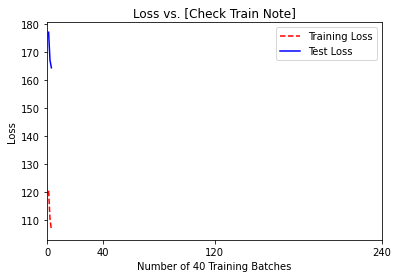

In [17]:
train(mini, 1, train_loader, test_loader, 0.003, criterion, print_every = 40)

## Best VGG19 Model with Batchnorm (Random Weights)

In [ ]:
vgg19 = models.vgg19_bn()
vgg19.classifier = nn.Sequential(
    nn.Linear(vgg19.classifier[0].in_features, 1000),
    nn.ReLU(inplace = True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(1000, 500),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(500, 10))
print(vgg19.classifier)
train(vgg19, 1, train_loader, test_loader, 0.03, criterion, print_every = 10)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth



Sequential(
  (0): Linear(in_features=25088, out_features=1000, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1000, out_features=500, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=500, out_features=10, bias=True)
)
Device: cuda
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.03
    lr: 0.03
    weight_decay: 0
)
Epoch: 1/1 | Batch Number: 10 | Learning Rate: 0.03000000 | Train Loss: 1715.26 | Train Accuracy 12.29% | Test Loss: 455.15 | Test Accuracy 13.44%
Epoch: 1/1 | Batch Number: 20 | Learning Rate: 0.03000000 | Train Loss: 38.52 | Train Accuracy 9.38% | Test Loss: 281.56 | Test Accuracy 10.69%
Epoch: 1/1 | Batch Number: 30 | Learning Rate: 0.03000000 | Train Loss: 44.28 | Train Accuracy 10.21% | Test Loss: 244.52 | Test Accuracy 10.21%
Epoch: 1/1 | Batch Number: 40 | Learning Rate: 0.03000000 | Train Loss: 25.05

KeyboardInterrupt: ignored

## Resnet Models Random Weights

In [ ]:
def choose_resnet(model_name):

  assert type(model_name) == str

  resnet = eval("models.{}()".format(model_name))
  resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 1000),
    nn.ReLU(inplace = True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(1000, 500),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(500, 10))
  print(resnet.fc)
  return resnet

In [ ]:
#Instantiate all the resnet models
resnet18 = choose_resnet("resnet18")
resnet50 = choose_resnet("resnet50")
resnet152 = choose_resnet("resnet152")

Sequential(
  (0): Linear(in_features=512, out_features=1000, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1000, out_features=500, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=500, out_features=10, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=1000, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1000, out_features=500, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=500, out_features=10, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=1000, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1000, out_features=500, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=500, out_features=10, bias=True)
)


In [ ]:
train(resnet18, 1, train_loader, test_loader, 0.003, criterion, print_every = 10)

Device: cuda
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.003
    lr: 0.003
    weight_decay: 0
)
Epoch: 1/1 | Batch Number: 10 | Learning Rate: 0.00300000 | Train Loss: 25.17 | Train Accuracy 11.04% | Test Loss: 60344.55 | Test Accuracy 10.21%
Epoch: 1/1 | Batch Number: 20 | Learning Rate: 0.00300000 | Train Loss: 23.38 | Train Accuracy 9.17% | Test Loss: 3417.10 | Test Accuracy 10.94%
Epoch: 1/1 | Batch Number: 30 | Learning Rate: 0.00300000 | Train Loss: 23.05 | Train Accuracy 10.42% | Test Loss: 523.49 | Test Accuracy 12.01%
Epoch: 1/1 | Batch Number: 40 | Learning Rate: 0.00300000 | Train Loss: 22.72 | Train Accuracy 11.04% | Test Loss: 577.42 | Test Accuracy 12.45%
Epoch: 1/1 | Batch Number: 50 | Learning Rate: 0.00300000 | Train Loss: 22.50 | Train Accuracy 15.42% | Test Loss: 186.26 | Test Accuracy 15.96%


KeyboardInterrupt: ignored

In [ ]:
train(resnet50, 1, train_loader, test_loader, 0.003, criterion, print_every = 10)

In [ ]:
train(resnet152, 1, train_loader, test_loader, 0.003, criterion, print_every = 10)